In [1]:
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

In [2]:
def preprocessing(words):
    unwanted_chars = ['ß', 'à', 'ä', 'ç', 'è', 'é', 'ï', 'ñ', 'ó', 'ö', 'ü', 'ā']

    def contains_unwanted_chars(word):
        return any(char in unwanted_chars for char in word)

    words = [haiku for haiku in words if not any(contains_unwanted_chars(word) for word in haiku)]
    return words

def load_data(path):
    with open(path, 'r') as f:
        words = f.read().splitlines()
    words = preprocessing(words)
    return words

words = load_data('../lines.txt')
chars = sorted(list(set(''.join(words)))) #+ ["<S>", "<M>", "<E>"]
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

In [3]:
class CharDataset(Dataset):
    def __init__(self, words, chars, max_word_length):
        self.words = words
        self.chars = chars
        self.max_word_length = max_word_length
        self.stoi = {ch:i+1 for i,ch in enumerate(chars)}
        self.itos = {i:s for s,i in self.stoi.items()}

    def __len__(self):
        return len(self.words)

    def contains(self, word):
        return word in self.words

    def get_vocab_size(self):
        return len(self.chars) + 1

    def get_output_length(self):
        return self.max_word_length + 1

    def encode(self, word):
        ix = torch.tensor([self.stoi[w] for w in word], dtype=torch.long)
        return ix

    def decode(self, ix):
        word = ''.join(self.itos[i] for i in ix)
        return word

    def __getitem__(self, idx):
        word = self.words[idx]
        ix = self.encode(word)
        x = torch.zeros(self.max_word_length + 1, dtype=torch.long)
        y = torch.zeros(self.max_word_length + 1, dtype=torch.long)
        x[1:1+len(ix)] = ix
        y[:len(ix)] = ix
        y[len(ix)+1:] = -1 

        return x, y

class RNNCell(nn.Module):
    """
    the job of a 'Cell' is to:
    take input at current time step x_{t} and the hidden state at the
    previous time step h_{t-1} and return the resulting hidden state
    h_{t} at the current timestep
    """
    def __init__(self, config):
        super().__init__()
        # self.wxh_to_h = torch.randn(config.n_embd + config.n_embd2, config.n_embd2) * 5/3 / math.sqrt(config.n_embd + config.n_embd2)
        # self.bxh_to_h = torch.zeros(config.n_embd2) * 0
        self.xh_to_h = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)

    def forward(self, xt, hprev):
        xh = torch.cat([xt, hprev], dim=1)
        # ht = torch.tanh(xh @ self.wxh_to_h + self.bxh_to_h)
        ht = torch.tanh(self.xh_to_h(xh))
        return ht

class RNN(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.start = nn.Parameter(torch.zeros(1, config.n_embd2))
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.cell = RNNCell(config)
        self.out_cell = nn.Linear(config.n_embd2, self.vocab_size)

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):
        b, t = idx.size()

        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        emb = self.wte(idx)
        hprev = self.start.expand((b, -1))
        hiddens = []

        for i in range(t):
            xt = emb[:, i, :]
            ht = self.cell(xt, hprev)
            hprev = ht
            hiddens.append(ht)

        hidden = torch.stack(hiddens, 1)
        logits = self.out_cell(hidden)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss

def train_rnn(model, batch_loader, epochs=50000, learning_rate=0.01):
    optimizer = torch.optim.AdamW(model.parameters(), 
                                lr=learning_rate, 
                                weight_decay=0.01, 
                                betas=(0.9, 0.99), 
                                eps=1e-8)
    all_losses = []
    all_iters = []
    
    for epoch in range(epochs):
        batch = batch_loader.next()
        X, Y = batch

        # feed into the model
        _, loss = model(X, Y)

        # backprop
        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"step {epoch} | loss {loss.item():.4f}")

        all_losses.append(loss.item())
        all_iters.append(epoch)

    return all_losses, all_iters

def create_datasets(input_file):
    words = open(input_file, 'r').read().splitlines()
    words = preprocessing(words)
    words = [w.replace("/", "").replace("$", "").replace("  ", " ").strip() for w in words] 
    words = [w for w in words if w]
    chars = sorted(list(set(''.join(words))))
    max_word_length = max(len(w) for w in words)
    
    test_set_size = min(1000, int(len(words) * 0.1))
    rp = torch.randperm(len(words)).tolist()
    train_words = [words[i] for i in rp[:-test_set_size]]
    test_words = [words[i] for i in rp[-test_set_size:]]
    print(f"split up the dataset into {len(train_words)} training examples and {len(test_words)} test examples")

    # wrap in dataset objects
    train_dataset = CharDataset(train_words, chars, max_word_length)
    test_dataset = CharDataset(test_words, chars, max_word_length)

    return train_dataset, test_dataset


In [4]:
class InfiniteDataLoader:
    def __init__(self, dataset, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration:
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch

@dataclass
class ModelConfig:
    block_size: int = None
    vocab_size: int = None
    n_embd: int = 64
    n_embd2: int = 64

train_dataset, test_dataset = create_datasets("../lines.txt")
vocab_size = train_dataset.get_vocab_size()
block_size = train_dataset.get_output_length()
config = ModelConfig(vocab_size=vocab_size, block_size=block_size)

print(f"vocab size: {vocab_size}")
print(f"block size: {block_size}")

batch_loader = InfiniteDataLoader(train_dataset, batch_size=32)
model = RNN(config)

split up the dataset into 10235 training examples and 1000 test examples
vocab size: 31
block size: 118


In [5]:
# print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
total_params

12319

In [11]:
all_losses, all_iters = train_rnn(model, batch_loader, epochs=1000)

step 0 | loss 3.5169
step 10 | loss 2.4297
step 20 | loss 2.3336
step 30 | loss 2.2732
step 40 | loss 2.1752
step 50 | loss 2.1668
step 60 | loss 2.1352
step 70 | loss 2.0560
step 80 | loss 2.1039
step 90 | loss 2.0406
step 100 | loss 2.0382
step 110 | loss 2.0332
step 120 | loss 1.9886
step 130 | loss 1.9472
step 140 | loss 1.9509
step 150 | loss 1.9982
step 160 | loss 2.0112
step 170 | loss 1.9204
step 180 | loss 1.9171
step 190 | loss 1.9459
step 200 | loss 1.9245
step 210 | loss 1.9492
step 220 | loss 1.9081
step 230 | loss 1.9414
step 240 | loss 2.0103
step 250 | loss 1.8585
step 260 | loss 1.9603
step 270 | loss 1.8833
step 280 | loss 1.8993
step 290 | loss 1.9189
step 300 | loss 1.9004
step 310 | loss 1.9299
step 320 | loss 1.8867
step 330 | loss 1.9019
step 340 | loss 1.8906
step 350 | loss 1.8996
step 360 | loss 1.8289
step 370 | loss 1.9109
step 380 | loss 1.8824
step 390 | loss 1.8811
step 400 | loss 1.9165
step 410 | loss 1.8960
step 420 | loss 1.8763
step 430 | loss 1.8963

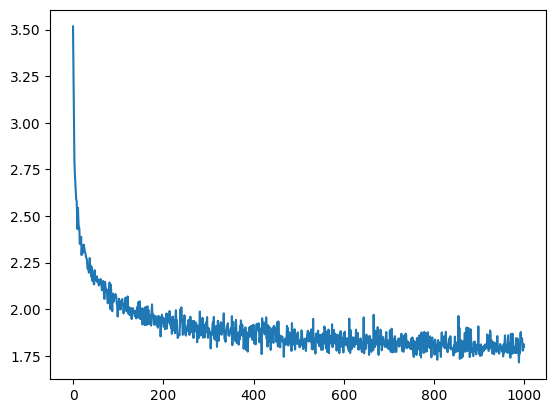

In [13]:
import matplotlib.pyplot as plt
plt.plot(all_iters, all_losses)

In [14]:
# test out the model
model.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
batch = next(iter(test_loader))
X, Y = batch
logits, loss = model(X, Y)
print("loss", loss.item())

loss 1.7784347534179688


## Comparable loss to Single Layer NN -> which is weird cause RNN is supposed to do better?

In [15]:
@torch.no_grad()
def generate(model, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):
    block_size = model.get_block_size()
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        if do_sample:
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            _, idx_next = torch.topk(probs, k=1, dim=-1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

def print_samples(num=10):
    X_init = torch.zeros(num, 1, dtype=torch.long)
    top_k = None
    steps = train_dataset.get_output_length() - 1 # -1 because we already start with <START> token (index 0)
    X_samp = generate(model, X_init, steps, top_k=top_k, do_sample=True).to('cpu')
    train_samples, test_samples, new_samples = [], [], []
    for i in range(X_samp.size(0)):
        row = X_samp[i, 1:].tolist()
        crop_index = row.index(0) if 0 in row else len(row)
        row = row[:crop_index]
        word_samp = train_dataset.decode(row)
        if train_dataset.contains(word_samp):
            train_samples.append(word_samp)
        elif test_dataset.contains(word_samp):
            test_samples.append(word_samp)
        else:
            new_samples.append(word_samp)
    print('-'*80)
    for lst, desc in [(train_samples, 'in train'), (test_samples, 'in test'), (new_samples, 'new')]:
        print(f"{len(lst)} samples that are {desc}:")
        for word in lst:
            print(word.replace("/", "").replace("$", "").replace("  ", " "))
    print('-'*80)


print_samples(num=10)

--------------------------------------------------------------------------------
0 samples that are in train:
0 samples that are in test:
10 samples that are new:
high whives now or thines and i whieps is night with hell amber the 'ad in glow are she groing dright to wavor a soul
thery stoon we forgy god kind
morn tid whery to takes
whiss mores thoom
waking fol tonet
pry wibling have an annoglest been pend of spla my muns so your known traiku apple with a hout findays do ralls lif
sleep my eyes way dirning hargy at am nats flome
i way whings soundel my breathe cagits sires exishly blaze deromates for zands snow on lifedy do long soft so her cha
the betime for in rimmines dife beft of han never on then't scain weeky like we hap softice please's can tenting a l
whren murn they her lost loolow much i unoat in the warm koss dowt jeirles did she a time
--------------------------------------------------------------------------------


## LSTM

In [100]:
# Inefficient implementation

class LSTMCell(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.stm = torch.zeros((config.vocab_size + 1, config.n_embd2))
        self.ltm = torch.zeros((config.vocab_size + 1, config.n_embd2))
        self.wforget = {
            "stm": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2),
            "input": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2)
        }
        self.winput = {
            "pltm": {
                "stm": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2),
                "input": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2)
            }, 
            "popltm": {
                "stm": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2),
                "input": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2)
            }
        }
        self.woutput = {
            "stm": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2),
            "input": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2)
        }
    
    def forward(self, xt):
        # forget gate
        xf = self.wforget["input"](xt)
        stmf = self.wforget["stm"](self.stm)

        # print(xf.shape, stmf.shape)

        fin = torch.sigmoid(xf + stmf)
        self.ltm *= fin

        #input gate
        xi = self.winput["pltm"]["input"](xt)
        stmi = self.winput["pltm"]["stm"](self.stm)
        io = torch.tanh(xi + stmi)

        xip = self.winput["popltm"]["input"](xt)
        stmip = self.winput["popltm"]["stm"](self.stm)
        iof = torch.sigmoid(xip + stmip)

        self.ltm += (iof * io)

        # output gate
        xo = self.woutput["input"](xt)
        stmo = self.woutput["stm"](self.stm)
        aux_out = torch.sigmoid(xo + stmo)

        fout = aux_out * (torch.tanh(self.ltm))
        self.stm = fout

        return fout
    
class LSTMCellEfficient(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.n_embd2
        self.weight = nn.Linear(config.n_embd + config.n_embd2, 4 * config.n_embd2)
        # self.dropout = nn.Dropout(p=0.2)  # Adding dropout
        # self.layer_norm = nn.LayerNorm(config.n_embd2)
        # self.dropout = nn.Dropout(p=0.2)
    def forward(self, xt, stm, ltm):
        combined = torch.cat((xt, stm), dim=-1)
        gates = self.weight(combined)
        f_gate, i_gate, o_gate, g_gate = gates.chunk(4, dim=-1)

        f_gate = torch.sigmoid(f_gate)
        i_gate = torch.sigmoid(i_gate)
        o_gate = torch.sigmoid(o_gate)
        g_gate = torch.tanh(g_gate)

        ltm = f_gate * ltm + i_gate * g_gate
        stm = o_gate * torch.tanh(ltm)

        # stm = self.layer_norm(stm)
        # stm = self.dropout(stm)

        return stm, ltm

In [101]:
def train_rnn(model, config, batch_loader, epochs=50000, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), 
                                lr=learning_rate)

    all_losses = []
    all_iters = []
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    for epoch in range(epochs):
        batch = batch_loader.next()
        X, Y = batch

        stm = torch.zeros(X.size(0), config.n_embd2, device=X.device)
        ltm = torch.zeros(X.size(0), config.n_embd2, device=X.device)

        stm, ltm, loss, _ = model(X, Y, stm, ltm)

        # Backpropagation
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        # scheduler.step(loss)

        if epoch % 10 == 0:
            print(f"step {epoch} | loss {loss.item():.4f}")

        all_losses.append(loss.item())
        all_iters.append(epoch)

    return all_losses, all_iters


In [102]:
class RNN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.start = nn.Parameter(torch.zeros(1, config.n_embd2))
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.cell = LSTMCellEfficient(config)
        self.out_cell = nn.Linear(config.n_embd2, self.vocab_size)

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None, ltm=None, stm=None):
        b, t = idx.size()

        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        emb = self.wte(idx)
        hiddens = []

        for i in range(t):
            xt = emb[:, i, :]
            stm, ltm = self.cell(xt, stm, ltm)
            hiddens.append(stm)

        hidden = torch.stack(hiddens, 1)
        logits = self.out_cell(hidden)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return stm, ltm, loss, logits   


In [103]:
batch_loader = InfiniteDataLoader(train_dataset, batch_size=64)
lstm = RNN(config)
all_losses, all_iters = train_rnn(lstm, config, batch_loader, epochs=1000)

step 0 | loss 3.4220
step 10 | loss 2.5692
step 20 | loss 2.3762
step 30 | loss 2.2627
step 40 | loss 2.2135
step 50 | loss 2.1278
step 60 | loss 2.0877
step 70 | loss 2.0581
step 80 | loss 2.0631
step 90 | loss 2.0436
step 100 | loss 2.0193
step 110 | loss 1.9706
step 120 | loss 1.9802
step 130 | loss 1.9519
step 140 | loss 1.8822
step 150 | loss 1.9320
step 160 | loss 1.8753
step 170 | loss 1.9364
step 180 | loss 1.8267
step 190 | loss 1.8331
step 200 | loss 1.8366
step 210 | loss 1.8117
step 220 | loss 1.8533
step 230 | loss 1.8686
step 240 | loss 1.8280
step 250 | loss 1.8044
step 260 | loss 1.8423
step 270 | loss 1.8485
step 280 | loss 1.8006
step 290 | loss 1.8178
step 300 | loss 1.8044
step 310 | loss 1.7970
step 320 | loss 1.8321
step 330 | loss 1.7857
step 340 | loss 1.7852
step 350 | loss 1.7961
step 360 | loss 1.7579
step 370 | loss 1.7810
step 380 | loss 1.7621
step 390 | loss 1.7616
step 400 | loss 1.7252
step 410 | loss 1.7277
step 420 | loss 1.7510
step 430 | loss 1.7323

In [134]:
@torch.inference_mode()
def evaluate(model, dataset, batch_size=50, max_batches=None):
    model.eval()
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=0)
    losses = []
    for i, batch in enumerate(loader):
        # batch = [t.to(args.device) for t in batch]
        X, Y = batch
        ltm = torch.zeros(X.size(0), config.n_embd2, device=X.device)
        stm = torch.zeros(X.size(0), config.n_embd2, device=X.device)
        stm, ltm, loss, _ = model(X, Y, stm, ltm)
        losses.append(loss.item())
        if max_batches is not None and i >= max_batches:
            break
    mean_loss = torch.tensor(losses).mean().item()
    model.train() # reset model back to training mode
    return mean_loss

evaluate(lstm, test_dataset, batch_size=64), evaluate(lstm, train_dataset, batch_size=64)

(1.6703948974609375, 1.6663955450057983)

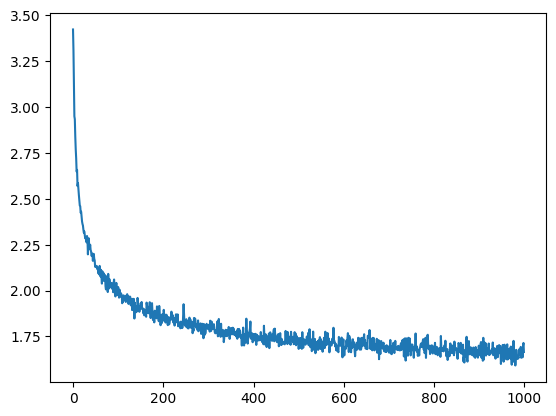

In [109]:
import matplotlib.pyplot as plt
plt.plot(all_iters, all_losses)

In [113]:
@torch.no_grad()
def generate(model, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):
    block_size = model.get_block_size()
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        stm = torch.zeros(10, config.n_embd2, device=X.device)
        ltm = torch.zeros(10, config.n_embd2, device=X.device)
        _, _, _, logits = model(idx_cond, stm=stm, ltm=ltm)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        if do_sample:
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            _, idx_next = torch.topk(probs, k=1, dim=-1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

def print_samples(num=10):
    X_init = torch.zeros(num, 1, dtype=torch.long)
    top_k = None
    steps = train_dataset.get_output_length() - 1 # -1 because we already start with <START> token (index 0)
    X_samp = generate(lstm, X_init, steps, top_k=top_k, do_sample=True).to('cpu')
    train_samples, test_samples, new_samples = [], [], []
    for i in range(X_samp.size(0)):
        row = X_samp[i, 1:].tolist()
        crop_index = row.index(0) if 0 in row else len(row)
        row = row[:crop_index]
        word_samp = train_dataset.decode(row)
        if train_dataset.contains(word_samp):
            train_samples.append(word_samp)
        elif test_dataset.contains(word_samp):
            test_samples.append(word_samp)
        else:
            new_samples.append(word_samp)
    print('-'*80)
    for lst, desc in [(train_samples, 'in train'), (test_samples, 'in test'), (new_samples, 'new')]:
        print(f"{len(lst)} samples that are {desc}:")
        for word in lst:
            print(word.replace("/", "").replace("$", "").replace("  ", " "))
    print('-'*80)


print_samples(num=10)

--------------------------------------------------------------------------------
0 samples that are in train:
0 samples that are in test:
10 samples that are new:
who was not
my abouts courcice off lawning than more anotherce's all sounds
turned why ner tried and plain
the head there the saddall litenine husfect from a pain but
beaued diving the fink dreach thoughtle heart your ass no is
when crippoke in the lunds you
thanks in come the brush while are a treath afulate today
blow there i love laives and the somed me
her ferous i face somest braps and appleaping sharming the bloom and san interbude this smile door tears have me stie
wheelvess blurous lonely by the waits furter
--------------------------------------------------------------------------------


In [121]:
class GRUCell(nn.Module):
    """
    same job as RNN cell, but a bit more complicated recurrence formula
    that makes the GRU more expressive and easier to optimize.
    """
    def __init__(self, config):
        super().__init__()
        # input, forget, output, gate
        self.xh_to_z = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.xh_to_r = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.xh_to_hbar = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)

    def forward(self, xt, hprev):
        # first use the reset gate to wipe some channels of the hidden state to zero
        xh = torch.cat([xt, hprev], dim=1)
        r = F.sigmoid(self.xh_to_r(xh))
        hprev_reset = r * hprev
        # calculate the candidate new hidden state hbar
        xhr = torch.cat([xt, hprev_reset], dim=1)
        hbar = F.tanh(self.xh_to_hbar(xhr))
        # calculate the switch gate that determines if each channel should be updated at all
        z = F.sigmoid(self.xh_to_z(xh))
        # blend the previous hidden state and the new candidate hidden state
        ht = (1 - z) * hprev + z * hbar
        return ht

class RNN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.start = nn.Parameter(torch.zeros(1, config.n_embd2)) # the starting hidden state
        self.wte = nn.Embedding(config.vocab_size, config.n_embd) # token embeddings table
        self.cell = GRUCell(config)
        self.lm_head = nn.Linear(config.n_embd2, self.vocab_size)

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()

        # embed all the integers up front and all at once for efficiency
        emb = self.wte(idx) # (b, t, n_embd)

        # sequentially iterate over the inputs and update the RNN state each tick
        hprev = self.start.expand((b, -1)) # expand out the batch dimension
        hiddens = []
        for i in range(t):
            xt = emb[:, i, :] # (b, n_embd)
            ht = self.cell(xt, hprev) # (b, n_embd2)
            hprev = ht
            hiddens.append(ht)

        # decode the outputs
        hidden = torch.stack(hiddens, 1) # (b, t, n_embd2)
        logits = self.lm_head(hidden)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss
    


In [122]:
def train_rnn(model, batch_loader, epochs=1000, learning_rate=0.01):
    optimizer = torch.optim.AdamW(model.parameters(), 
                                lr=learning_rate, 
                                weight_decay=0.01, 
                                betas=(0.9, 0.99), 
                                eps=1e-8)
    all_losses = []
    all_iters = []
    
    for epoch in range(epochs):
        batch = batch_loader.next()
        X, Y = batch

        # feed into the model
        _, loss = model(X, Y)

        # backprop
        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"step {epoch} | loss {loss.item():.4f}")

        all_losses.append(loss.item())
        all_iters.append(epoch)

    return all_losses, all_iters

train_dataset, test_dataset = create_datasets("../lines.txt")
vocab_size = train_dataset.get_vocab_size()
block_size = train_dataset.get_output_length()
config = ModelConfig(vocab_size=vocab_size, block_size=block_size)

print(f"vocab size: {vocab_size}")
print(f"block size: {block_size}")

split up the dataset into 10235 training examples and 1000 test examples
vocab size: 31
block size: 118


In [123]:
model = RNN(config)

# print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
total_params

28831

In [124]:
batch_loader = InfiniteDataLoader(train_dataset, batch_size=64)
all_losses, all_iters = train_rnn(model, batch_loader)

step 0 | loss 3.4325
step 10 | loss 2.4464
step 20 | loss 2.3149
step 30 | loss 2.2272
step 40 | loss 2.1053
step 50 | loss 2.1246
step 60 | loss 2.0706
step 70 | loss 1.9713
step 80 | loss 1.9576
step 90 | loss 1.9241
step 100 | loss 1.9677
step 110 | loss 1.8760
step 120 | loss 1.8882
step 130 | loss 1.8793
step 140 | loss 1.8603
step 150 | loss 1.8323
step 160 | loss 1.8965
step 170 | loss 1.7817
step 180 | loss 1.8150
step 190 | loss 1.8310
step 200 | loss 1.8068
step 210 | loss 1.7648
step 220 | loss 1.7720
step 230 | loss 1.7534
step 240 | loss 1.7788
step 250 | loss 1.7791
step 260 | loss 1.7783
step 270 | loss 1.7560
step 280 | loss 1.7706
step 290 | loss 1.7417
step 300 | loss 1.8098
step 310 | loss 1.7348
step 320 | loss 1.7630
step 330 | loss 1.7627
step 340 | loss 1.7693
step 350 | loss 1.7169
step 360 | loss 1.7257
step 370 | loss 1.7295
step 380 | loss 1.6881
step 390 | loss 1.7214
step 400 | loss 1.6884
step 410 | loss 1.7390
step 420 | loss 1.7242
step 430 | loss 1.7579

In [132]:
@torch.inference_mode()
def evaluate(model, dataset, batch_size=50, max_batches=None):
    model.eval()
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=0)
    losses = []
    for i, batch in enumerate(loader):
        # batch = [t.to(args.device) for t in batch]
        X, Y = batch
        _, loss = model(X, Y)
        losses.append(loss.item())
        if max_batches is not None and i >= max_batches:
            break
    mean_loss = torch.tensor(losses).mean().item()
    model.train() # reset model back to training mode
    return mean_loss

evaluate(model, train_dataset, batch_size=64), evaluate(model, test_dataset, batch_size=64)

(1.6554149389266968, 1.6813082695007324)

In [129]:
@torch.no_grad()
def generate(model, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):
    block_size = model.get_block_size()
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        if do_sample:
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            _, idx_next = torch.topk(probs, k=1, dim=-1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

def print_samples(num=10):
    X_init = torch.zeros(num, 1, dtype=torch.long)
    top_k = None
    steps = train_dataset.get_output_length() - 1 # -1 because we already start with <START> token (index 0)
    X_samp = generate(model, X_init, steps, top_k=top_k, do_sample=True).to('cpu')
    train_samples, test_samples, new_samples = [], [], []
    for i in range(X_samp.size(0)):
        row = X_samp[i, 1:].tolist()
        crop_index = row.index(0) if 0 in row else len(row)
        row = row[:crop_index]
        word_samp = train_dataset.decode(row)
        if train_dataset.contains(word_samp):
            train_samples.append(word_samp)
        elif test_dataset.contains(word_samp):
            test_samples.append(word_samp)
        else:
            new_samples.append(word_samp)
    print('-'*80)
    for lst, desc in [(train_samples, 'in train'), (test_samples, 'in test'), (new_samples, 'new')]:
        print(f"{len(lst)} samples that are {desc}:")
        for word in lst:
            print(word.replace("/", "").replace("$", "").replace("  ", " "))
    print('-'*80)


print_samples(num=10)

--------------------------------------------------------------------------------
0 samples that are in train:
0 samples that are in test:
10 samples that are new:
happine looking your for endly to must hatit weak thy papn power today the oppoligart on you sound jousist
not dream i tay good
rain
going we feel noth i can'ore you never a travaid are way night time ok things on the tluts me't the grass guyta hat a
kinsesside infinued folution doesencer timevy
we con combored always leassy
deep usery birds not geam my phose rolling is i am i am fatching near i'm love embce bare findstary thighten zn the 
whole but salters tonestmally ha las twings brikn thick steer with then pomes cnarl so trucy starfract like sun to th
and your minitch a snaits the resty it of the world i thank a bonuuse of head down bull the cast reice in my grees as
the bure
--------------------------------------------------------------------------------


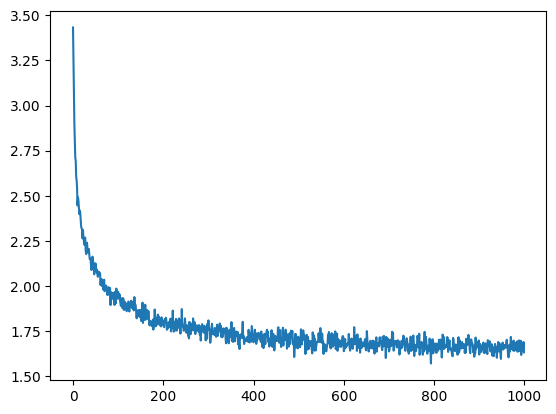

In [130]:
plt.plot(all_iters, all_losses)